# GAN Exercise

In this exercise I followed along with this article:
https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432

And attempted to generate images that look like dogs using the following dataset:
http://vision.stanford.edu/aditya86/ImageNetDogs/

My only issue was that the dataset the article uses is structured a bit differently since that one was from Kaggle and since that isn't available for download anymore I had to use the source. This required a couple of extra steps.

I'm using a simplfied code than what the article goes through in some respect such as:
- No spectral normalization.
- No relativistic loss function
- No evaluation
I also added some changes to the coda from the article:
- When I crop the images I took out some seemingly unnecessary calculations and I also save these cropped images. I do this because cropping out the new images can take quite a while and simply loading them up from a new folder is faster. One was to improve this even more would be to use a generator.
- Added reloading of the model weight before training so after kernel restart I continue from where I left off.
Now that I understand the code better I would like to try out the features I left out (spectral normalization, evaluation) and also try out new datasets. I'd also like to spend some time later tuning the Hyperparameters more.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt, zipfile
import os
import glob
import math
import random
import time
import datetime
import shutil
import imageio
from tqdm import tqdm, tqdm_notebook

from dataclasses import dataclass
from pathlib import Path
import warnings
from scipy import linalg

import xml.etree.ElementTree as ET 

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.contrib.eager.python import tfe

#from IPython import display

# libraries for SpectralNorm
from tensorflow.keras import backend as K
from keras.engine import *
from keras.legacy import interfaces
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils

Using TensorFlow backend.


In [2]:
os.listdir("../Classification Data")

['annotation.tar',
 'annotation_dogs',
 'dog-breed-identification',
 'dog-breed-identification.zip',
 'images_dogs',
 'images_dogs.tar']

In [3]:
tf.enable_eager_execution()

# Copy all dog images to one folder
Since the original dataset didn't come with an "all-dogs" folder but separated into subfolders of different breeds.

In [4]:
if False:
    # img dir: E:\Deep Learning\Classification Data\images_dogs\Images\n02086910-papillon
    # working dir: E:\Deep Learning\Notebooks
    #need to move dog images to one folder
    src_path = 'E:/Deep Learning/Classification Data/images_dogs/Images/'
    trgt_path = 'E:/Deep Learning/Classification Data/images_dogs/all_images/'

    breed_folders = os.listdir(src_path)
    #print(os.listdir(src_path+breed_folders[0]))
    for i, folder in tqdm_notebook(enumerate(breed_folders), total = len(breed_folders)):
        images = os.listdir(src_path+folder)
        for image in images:     
            img_open = Image.open(src_path + folder + '/' + image)
            if(np.array(img_open).shape[2] == 3):
                img_open.save(trgt_path + image)


# Input variables

In [5]:
image_width = 64
image_height = 64
image_channels = 3
image_sample_size = 10000
image_output_dir = "../gan_output_images/"
image_input_dir = "../Classification Data/images_dogs/Images/"
image_ann_dir = "../Classification Data/annotation_dogs/Annotation/"
image_cropped_dir = "../Classification Data/images_dogs/cropped_images/"
OUT_DIR = Path('../gan_output_images')
MODEL_PATH = '../gan_model/classify_image_graph_def.pb'
TRAIN_DIR = Path('../input/generative-dog-images/all-dogs/all-dogs/')

trgt_image_path = '../Classification Data/annotation_dogs/Annotation/'

In [6]:
# sanity check if the annotations contain the same amount of entries as the image folders
print(str(len(os.listdir(image_ann_dir + 'n02085620-Chihuahua'))))
print(str(len(os.listdir(image_input_dir + 'n02085620-Chihuahua'))))

152
152


# Image preprocessing and exploratory data analysis

In [7]:

dog_breed_dict = {}
for annotation in os.listdir(image_ann_dir):
    annotations = annotation.split('-')
    dog_breed_dict[annotations[0]]=annotations[1]


In [8]:
def read_image(src):
    img = cv2.imread(src)
    if img is None:
        raise FileNotFoundError
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Crop and apply scaling to images

In [9]:
os.listdir(image_ann_dir)

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [10]:
def load_cropped_images(dog_breed_dict=dog_breed_dict, image_ann_dir=image_ann_dir, sample_size=25000,
                       image_width=image_width, image_height=image_height, image_channels=image_channels):
    curIdx = 0
    breeds = []
    dog_images_np = np.zeros((sample_size,image_width,image_height,image_channels))
    for breed_folder in tqdm(os.listdir(image_ann_dir)):
        for dog_ann in os.listdir(image_ann_dir + breed_folder):
            #print(image_input_dir + breed_folder +'/' + dog_ann + '.jpg')
            img = read_image(image_input_dir + breed_folder +'/' + dog_ann + '.jpg')
            
            
            tree = ET.parse(os.path.join(image_ann_dir + breed_folder, dog_ann))
            root = tree.getroot()
            
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            objects = root.findall('object')
            for o_cnt,o in enumerate(objects):
                bndbox = o.find('bndbox')
                
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                
                xmin = max(0, xmin -4) #4 margin
                xmax = min(width,xmax+4)
                ymin = max(0, ymin - 4)
                ymax = min(height, ymax + 4)
                
                w = np.min((xmax - xmin, ymax -ymin))
                
                img_cropped = img[ymin:ymin+w, xmin:xmin+w, :]
                if xmax-xmin > image_width:
                    interpolation = cv2.INTER_AREA # shrinking
                else:
                    interpolation = cv2.INTER_CUBIC # expansion
                
                img_cropped = cv2.resize(img_cropped, (image_width, image_height), interpolation = interpolation)
                
                dog_images_np[curIdx,:,:,:] = np.asarray(img_cropped)
                dog_breed_name = dog_breed_dict[dog_ann.split('_')[0]]
                cv2.imwrite(image_cropped_dir + dog_ann + '_' + str(o_cnt) + '.jpg',
                            cv2.cvtColor(img_cropped, cv2.COLOR_RGB2BGR))
                breeds.append(dog_breed_name)
                curIdx += 1
    return dog_images_np, breeds
                    
                        
            


In [11]:
if False:
    start_time = time.time()
    dog_images_np, breeds = load_cropped_images(sample_size=22126)
    est_time = round(time.time()-start_time)
    print("Feature loading time: {}.".format(str(datetime.timedelta(seconds=est_time))))

# Optionally just load the images from the folder where the cropped images have been saved

In [12]:
def load_cropped_images_from_folder(image_cropped_dir = image_cropped_dir, image_width = image_width, image_height = image_height,
                       image_channels = image_channels, dog_breed_dict = dog_breed_dict):
    images = os.listdir(image_cropped_dir)
    sample_size = len(images)
    
    breeds = []
    dog_images_np = np.zeros((sample_size,image_width,image_height,image_channels))
    
    for i, image in tqdm_notebook(enumerate(images), total= sample_size):
        img = read_image(image_cropped_dir + image)
        dog_images_np[i,:,:,:] = np.asarray(img)
        dog_breed_name = dog_breed_dict[image.split('_')[0]]
        breeds.append(dog_breed_name)
    
    return dog_images_np, breeds

dog_images_np, breeds = load_cropped_images_from_folder(image_cropped_dir = image_cropped_dir, image_width = image_width, image_height = image_height,
                       image_channels = image_channels, dog_breed_dict = dog_breed_dict)



In [13]:
print('features shape. ', dog_images_np.shape)
print('labels: ', len(breeds))

features shape.  (22126, 64, 64, 3)
labels:  22126


In [14]:
def plot_features(features, labels, image_width=image_width, image_height=image_height,
                 image_channels=image_channels,
                 examples=25,
                 disp_labels=True):
    if not math.sqrt(examples).is_integer():
        print('Please select a valid number of examples.')
        return
    
    imgs = []
    classes = []
    
    for i in range(examples):
        rnd_idx = np.random.randint(0, len(labels))
        imgs.append(features[rnd_idx, :,:,:])
        classes.append(labels[rnd_idx])
        
    fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)), figsize = (15,15),
                            subplot_kw = {'xticks':[], 'yticks':[]}, 
                            gridspec_kw = dict(hspace=0.3, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        if disp_labels == True:
            ax.title.set_text(classes[i])
        ax.imshow(imgs[i])

plotting cropped images by their specified coordinates..


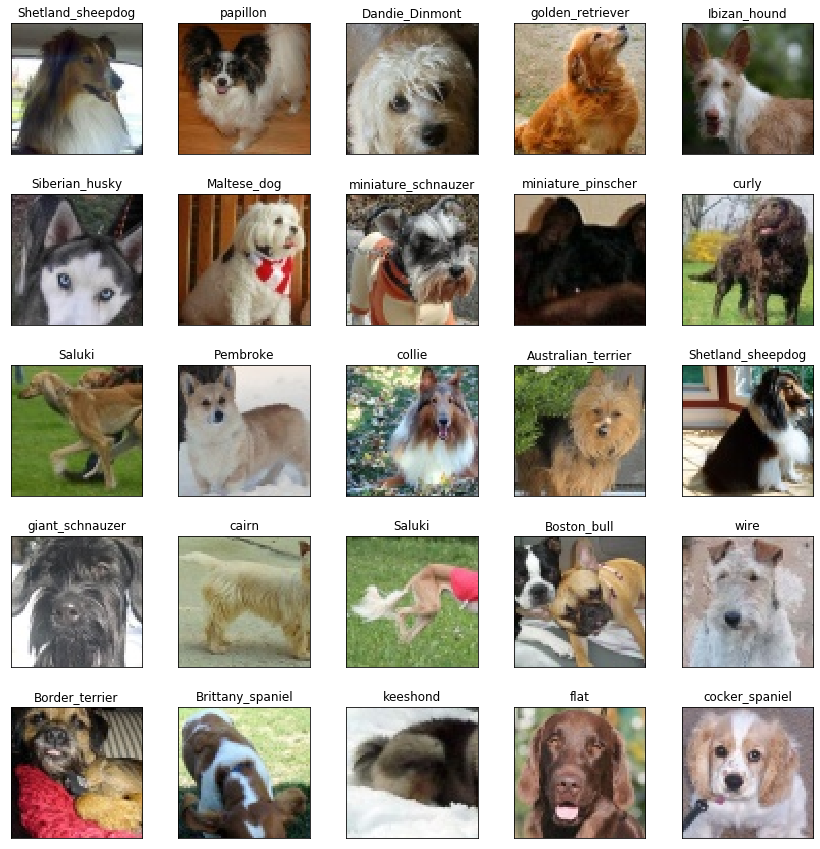

In [15]:
print('plotting cropped images by their specified coordinates..')
plot_features(dog_images_np /255., breeds, examples=25, disp_labels=True)

In [16]:
print(np.max(dog_images_np[10,:,:,:]), np.min(dog_images_np[10,:,:,:]))

242.0 0.0


In [17]:
dog_images_np_normalized = (dog_images_np - 127.5) / 127.5 # normalize images



In [18]:
print(np.max(dog_images_np_normalized[3,:,:,:]), np.min(dog_images_np_normalized[3,:,:,:]))

1.0 -1.0


plotting cropped images after normalization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

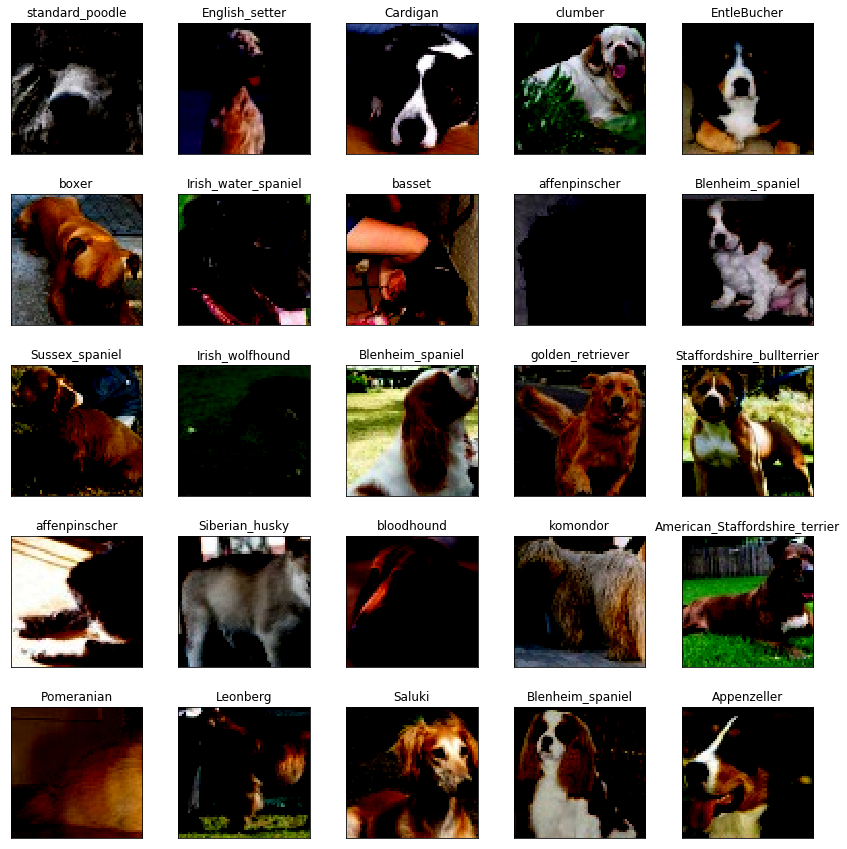

In [19]:
print("plotting cropped images after normalization")
plot_features(dog_images_np_normalized, breeds, examples = 25, disp_labels = True)

# Creating the dataset

In [20]:
print("Dog features shape: ", dog_images_np_normalized.shape)

Dog features shape:  (22126, 64, 64, 3)


In [21]:
dog_features_tf = tf.cast(dog_images_np_normalized, 'float32')

# Data Augmentation

In [22]:
def flip(x: tf.Tensor) -> (tf.Tensor):
    x = tf.image.random_flip_left_right(x)
    return x

def zoom(x: tf.Tensor) -> (tf.Tensor):
    # Generate 20 crop setting, ranging from a 1% to a 20% crop.
    scales = list(np.arange(0.7, 1.0, 0.01))
    boxes = np.zeros((len(scales),4))
    
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes = boxes, box_ind=np.zeros(len(scales)), crop_size = (64,64))
        #return a random crop
        return crops[tf.random_uniform(shape=[],minval=0,maxval=len(scales),dtype=tf.int32)]
    
    choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype = tf.float32)
    # Only apply cropping 50% of the time
    return (tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x)))

# Hyperparameters

In [23]:
sample_size = 22126
batch_size = 128
weight_init_std = 0.02
weight_init_mean = 0.0
leaky_relu_slope = 0.2
downsize_factor = 2
dropout_rate = 0.5
scale_factor = 4 ** downsize_factor
lr_initial_d = tfe.Variable(0.002)
lr_initial_g = tfe.Variable(0.0002)
lr_decay_steps = 1000
noise_dim = 128


# Create tensorflow-type dataset

In [24]:
dog_features_data = tf.data.Dataset.from_tensor_slices(dog_features_tf).shuffle(sample_size).map(flip).batch(batch_size, drop_remainder=True)
print(dog_features_data)

Instructions for updating:
Colocations handled automatically by placer.
<DatasetV1Adapter shapes: (128, 64, 64, 3), types: tf.float32>


In [25]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean,
                                                          seed=42)

In [26]:
def transposed_conv(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (ksize, ksize), strides = (stride_size, stride_size), padding = ptype,
                             kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides = (stride_size,stride_size), padding = 'same',
                    kernel_initializer = weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = leaky_relu_slope))
    return model

# Generator

In [27]:
def DogGenerator():
    model = Sequential()
    model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128,
                   input_shape=(noise_dim,), kernel_initializer = weight_initializer))
    model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 128)))
    
    model = transposed_conv(model, 512, ksize =5, stride_size = 1)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 256, ksize=5, stride_size=2)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 128, ksize=5, stride_size=2)
    model = transposed_conv(model, 64, ksize=5, stride_size=2)
    model = transposed_conv(model, 32, ksize=5, stride_size=2)
    model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))
    
    return model
    

In [28]:
dog_generator = DogGenerator()
print(dog_generator.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
___________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 64, 64, 3)
(5, 128) 0.073517784 0.9812323


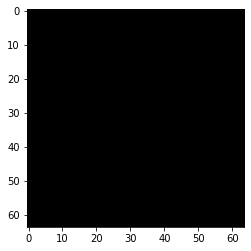

In [29]:
# random noise
noise = tf.random.normal([5, noise_dim])

generated_image = dog_generator(noise, training=False)
plt.imshow(generated_image[0,:,:,:])
print(generated_image.shape)
print(noise.shape, tf.math.reduce_mean(noise).numpy(), tf.math.reduce_std(noise).numpy())

# Discriminator

In [30]:
def DogDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False,
                         input_shape=[image_height, image_width, image_channels], 
                         kernel_initializer=weight_initializer))
    model.add(LeakyReLU(alpha=leaky_relu_slope))

    model = conv(model, 64, ksize=4, stride_size=2)
    model = conv(model, 128, ksize=4, stride_size=2)
    model = conv(model, 256, ksize=4, stride_size=2)

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [31]:
dog_discriminator = DogDiscriminator()
print(dog_discriminator.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        65536     
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131072    
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 8, 8, 128)         512       
__________

# Label Smoothing

In [32]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)
def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

# Add noise

In [33]:
def noisy_labels(y, p_flip):
    # number of labels to flip (as in change from positive to negative and vice versa)
    n_select = int(p_flip * int(y.shape[0])) # p * number_of_labels (usually 5%) and converted to int 
    
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size = n_select)
    
    op_list = []
    #invert the labels in place
    #y_np[lip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1, y[i]))
        else:
            op_list.append(y[i])
            
    outputs = tf.stack(op_list)
    return outputs

# Optimizer

In [34]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate = lr_initial_g, beta1 = 0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate = lr_initial_d, beta1 = 0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Cost function

In [35]:
def discriminator_loss(real_output, fake_output, smoothing_and_noise = True):
    
    if smoothing_and_noise:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output),0.05)
        real_output_smooth = smooth_positive_labels(real_output_noise)
        fake_output_smooth = smooth_negative_labels(fake_output_noise)
        real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
    else:
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        
    total_loss = real_loss + fake_loss
    return total_loss

In [36]:
def generator_loss(real_output, fake_output, apply_smoothing=True):
    if apply_smoothing:
        fake_output_smooth = smooth_positive_labels(tf.ones_like(fake_output))
        return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)
    else:
        return cross_entropy(tf.ones_like(fake_output), fake_output)

 # Callbacks

In [37]:
checkpoint_dir = 'gan_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator = dog_generator,
                                discriminator = dog_discriminator)

gan_checkpoints\ckpt


In [38]:
EPOCHS = 1
num_examples_to_generate = 64
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Training steps:
    1. Forward prop - G creates a batch of fake images, this alongside a batch of real images is fed to D.
    2. Calculate both G and D's loss function.
    3. Backprop - compute gradients for G and D optimize the weights.

In [39]:
def train_step(images):
    batch_size =images.shape[0]
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = dog_generator(noise, training = True)
        
        real_output = dog_discriminator(images, training = True)
        fake_output = dog_discriminator(generated_images, training= True)
        
        gen_loss = generator_loss(real_output, fake_output, True)
        disc_loss = discriminator_loss(real_output, fake_output, True)
        

   
    gradients_of_generator = gen_tape.gradient(gen_loss, dog_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dog_discriminator.trainable_variables)
    

    generator_optimizer.apply_gradients(zip(gradients_of_generator, dog_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dog_discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [40]:
def plot_losses(G_losses, D_losses, all_gl, all_dl, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(all_gl)),all_gl,label='G')
    plt.plot(np.arange(len(all_dl)),all_dl,label='D')
    plt.legend()
    #plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
    plt.title('All Time Loss')
    plt.show()

In [41]:
def generate_and_save_images(model, epoch, test_input, rows, cols):
    predictions = model(test_input, training =  False)
    fig = plt.figure(figsize = (14,14))
    for i in range(predictions.shape[0]):
        plt.subplot(rows,cols, i+1)
        plt.imshow((predictions[i,:,:,:] *127.5 + 127.5) / 255.)
        plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('Image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [42]:
def generate_test_image(model, noise_dim=noise_dim):
    test_input = tf.random.normal([1, noise_dim])
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0,:,:,:] * 127.5 + 127.5) / 255.)
    plt.axis('off')
    plt.show()

In [43]:
def zip_images(filename='images.zip'):
    # SAVE TO ZIP FILE NAMED IMAGES.ZIP
    z = zipfile.PyZipFile(filename, mode='w')
    for k in range(image_sample_size):
        generated_image = dog_generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height,image_width,image_channels)))
        img.save(f,'PNG')
        z.write(f)
        os.remove(f)
        #if k % 1000==0: print(k)
    z.close()
    print('Saved final images for submission.')
    
def save_images(directory=OUT_DIR):
    for k in range(image_sample_size):
        generated_image = dog_generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        f = os.path.join(directory, f)
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height,image_width,image_channels)))
        img.save(f,'PNG')
        #if k % 1000==0: print(k)
    print('Saved temporary images for evaluation.')

In [44]:
display_results = 40
decay_step = 50

In [45]:
def train(dataset, epochs):
    
    all_gl = np.array([]); all_dl = np.array([])
    
    exp_replay = []
    for epoch in tqdm(range(epochs)):
        
        G_loss = []; D_loss = []
        
        start = time.time()
        new_lr_d = lr_initial_d
        new_lr_g = lr_initial_g
        global_step = 0
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            global_step = global_step + 1
            G_loss.append(g_loss); D_loss.append(d_loss)
            all_gl = np.append(all_gl,np.array([G_loss]))
            all_dl = np.append(all_dl,np.array([D_loss]))
         
        #display.clear_output(wait=True)
        if (epoch + 1) % display_results == 0 or epoch == 0:
            plot_losses(G_loss, D_loss, all_gl, all_dl, epoch + 1)
            generate_and_save_images(dog_generator, epoch + 1, seed, rows=8, cols=8)
        
        # Cosine learning rate decay
        if (epoch + 1) % decay_step == 0:
            new_lr_d = tf.train.cosine_decay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_g = tf.train.cosine_decay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = tf.train.AdamOptimizer(learning_rate=new_lr_d, beta1=0.5)
            discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=new_lr_g, beta1=0.5)          

        print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start))
        print('Gen_loss mean: ', np.mean(G_loss),' std: ', np.std(G_loss))
        print('Disc_loss mean: ', np.mean(D_loss),' std: ', np.std(D_loss))

    generate_and_save_images(dog_generator, epochs, seed, rows=8, cols=8)
    checkpoint.save(file_prefix = checkpoint_prefix)    
    
    print('Final epoch.')

In [46]:
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  0%| | 0/1 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


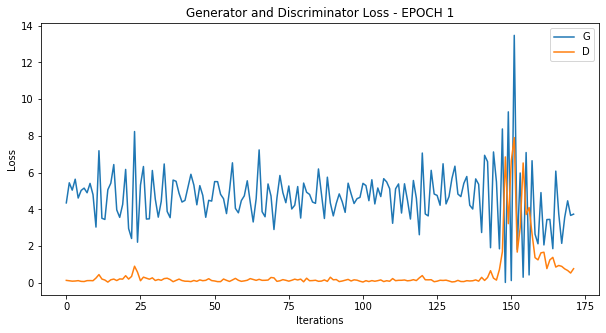

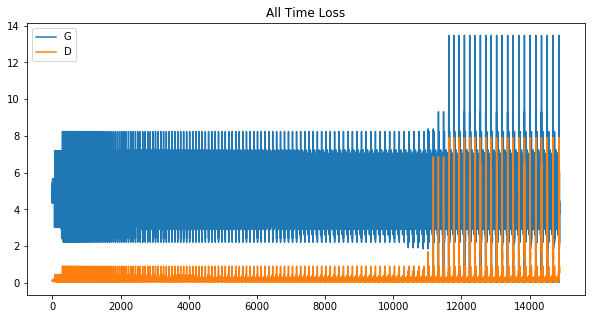

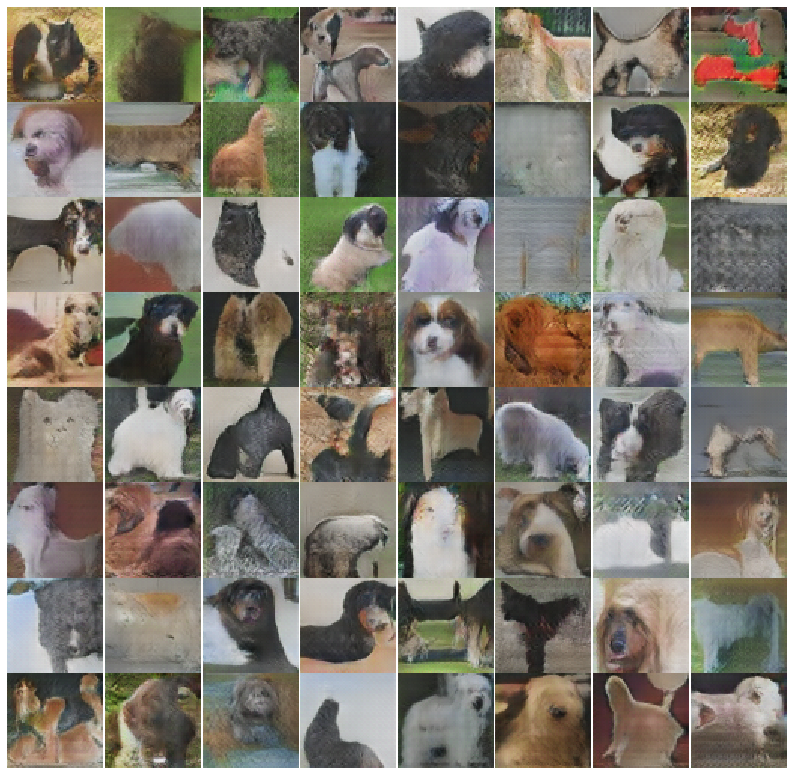

Epoch: 1 computed for 47.99440956115723 sec
Gen_loss mean:  4.6683483  std:  1.5764198
Disc_loss mean:  0.5084967  std:  1.1775893


100%|█| 1/1 [00:48<00:00, 48.13s/it]


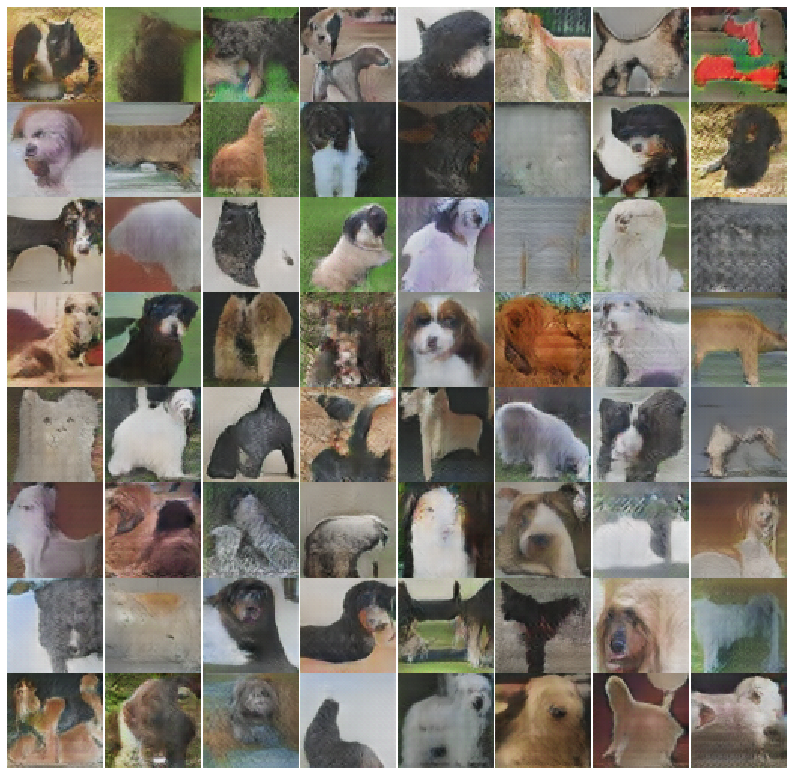

Final epoch.


In [47]:
#%%time
train(dog_features_data,1)

As you can see the pictures are actually starting to look like dogs at this point which is the best I've seen trying out a GAN so far. The tutorial I followed was really good at explaining the inner workings of the model and has been a great learning experience.